# Test

In [131]:
import tensorflow as tf

from tensorflow import keras

In [132]:
#TEMP LIBRARIES

#library to read and import file from drive
import os
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#images
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn_image as isns
import skimage.exposure

import numpy as np
from numpy.random import default_rng
import random
import imutils

#### Functions

In [133]:
def load_model(path="./"):
    return keras.models.load_model(path)

## Load pretrained model

In [134]:
autoencoder = load_model("../Models/autoencoderFC")

## Test image differences

## Functions from preparation

In [135]:
# Function to divide images into smaller parts
def split_patches(img, n_patches=16):
    imgs_list = []
    dim = int(img.shape[0]//(16**(1/2)))
    for i in range(0, n_patches):
        x = int(dim*(i%(16**(1/2))))
        y = int(dim*(i//(16**(1/2))))
        imgs_list.append(img[y:y+dim, x:x+dim])
    return imgs_list

In [136]:
# Function to scale pixel values from 0..255 to 0..1
def scale_pixels(img, scale_range=(0, 1)):
    return img.astype('float32') / 255.

In [137]:
# Function to resize images
def resize(img, size=(1024, 1024)):
    return cv.resize(img, size)

In [138]:
# Function to crop image 
def crop(img, mask=False):
    #gaussian filter
    tmp = cv.GaussianBlur(img,(21,21),0)

    ret1, th1 = cv.threshold(tmp, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret2, th2 = cv.threshold(img, 120, 255, cv.THRESH_BINARY)

    x, y, w, h = cv.boundingRect(th1)

    if(w<h):
        diff = h-w
        y = y+(diff//2)
        h = h-diff
    #return input image with crop and in b&w
    border = 50
    if(mask):
        return th2[y-border:y+h+border, x-border:x+w+border]
    return img[y-border:y+h+border, x-border:x+w+border]

## Model evaluation

In [139]:
img = cv.imread('../Data/Prepared/Test/NOK/NOK_2.jpg', cv.IMREAD_GRAYSCALE)

In [140]:
def calc_image_diff(true_img, rec_img):    
    # All values between 0 and 1
    rec_img[np.where((rec_img > [1]))] = 1
    rec_img[np.where((rec_img < [0]))] = 0

    # Calculate the difference between the original image and the reconstructed one
    diff = cv.absdiff(true_img, rec_img)

    # Scale values from 0..1 to 0..255 (required for opencv functions)
    diff = (diff*255).astype('uint8')
    return diff

In [141]:
def localize_anom(img, diff):
    anomaly = False
    # Threshold to make the image only white and black (so higlight the anomalies in white)
    ret, th = cv.threshold(diff, 150, 255, cv.THRESH_BINARY)

    # Find the countours of the anomalies
    cnts, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # For every anomaly, draw the bounding box
    anomalies_img = img.copy()
    for c in cnts:
        (x, y, w, h) = cv.boundingRect(c)
        anomalies_img = cv.rectangle(img, (x-20, y-20), (x + w + 20, y + h + 20), (0, 255, 0), 2)
        # If some anomaly is found, we classify the image as anomalous
        anomaly=True
        
    return anomaly, anomalies_img

In [142]:
def predict_image(img, model):
    # Preprocess
    img = crop(img)
    img = resize(img)
    img = scale_pixels(img)
    slices = split_patches(img)
    slices_anomal_bound = []

    # Get the reconstructed images from the model
    for slice in slices:
        slice_rec = model.predict(np.expand_dims(np.expand_dims(slice, 0), -1))
        slice_rec = np.squeeze(slice_rec[0], -1)
        diff = calc_image_diff(slice, slice_rec)
        slices_anomal_bound.append(diff)

    # Reconstruct the full image difference 
    horizion_concat = []
    for i in range(0, 16, 4):
        horizion_concat.append(cv.hconcat([slices_anomal_bound[i], slices_anomal_bound[i+1], slices_anomal_bound[i+2], slices_anomal_bound[i+3]]))
    img_total_anom = cv.vconcat([horizion_concat[0], horizion_concat[1], horizion_concat[2], horizion_concat[3]])

    # Detect and localize possible anomalies
    anomaly, anomalies_img = localize_anom(img, img_total_anom)

    return anomaly, anomalies_img


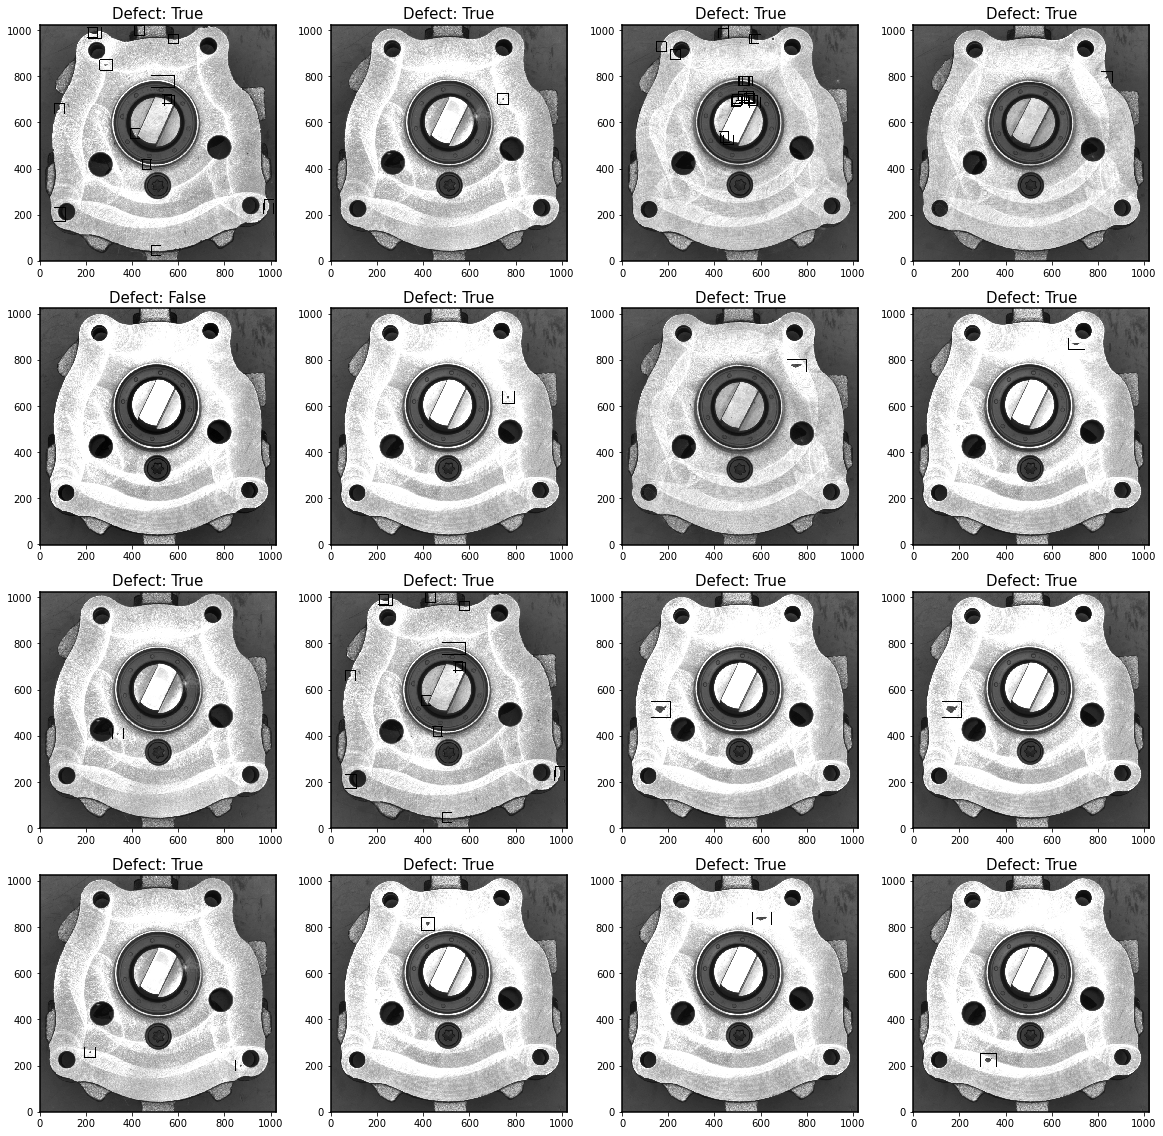

In [143]:
plt.figure(figsize=(20, 20))
i=1
for img_name in os.listdir('../Data/Prepared/Test/NOK'):
    img= cv.imread('../Data/Prepared/Test/NOK' + '/' + img_name, cv.IMREAD_GRAYSCALE)
    anom, img_anom = predict_image(img, autoencoder)
    plt.subplot(4, 4, i)
    plt.title('Defect: ' + str(anom))
    plt.imshow(img_anom, cmap='gray')
    i=i+1
plt.savefig('../test.jpg', facecolor='white')